In [4]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import glob
import sys
#import scvi
import gc
import re
import cytopus as cp
import gseapy as gp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

In [2]:
from utils import cond_cols, pop_cols, ct_map, grouped_obs_mean

In [3]:
spectra_file = '../../test/test123/write/qc_020725.spectra_out.4k.h5ad'

## Functions

In [55]:
def harmonize_str(x):

    return(x.replace(" ", "_").replace("+", "pos").replace("-", "neg").replace("/", "_"))

In [56]:
def lmm_allconds(adata, ctype_fracs):

    scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], 
                             index=adata.obs.index, columns=adata.uns['SPECTRA_overlap'].index)
    
    scores_means = scores_df.merge(adata.obs[['FID','COND','cytopus_names']], left_index=True, right_index=True) \
        .groupby(['FID','COND','cytopus_names']).mean().reset_index()\
        .merge(adata.obs[['FID','AGE','SEX','Ethnicity']].drop_duplicates())

    # polarize Ethnicity and condition
    scores_means['Ethnicity'] = pd.Categorical(scores_means['Ethnicity'], categories=["Tikari","Fulani","CHG"])
    scores_means['COND'] = pd.Categorical(scores_means['COND'], categories=["CTL","IFN","LPS"])

    # scores_means[focal_pop] = pd.Categorical([focal_pop if i==focal_pop else 'Other' for i in scores_means['Ethnicity']], 
    #                                          categories=['Other',focal_pop])

    # Drop Progenitor, DNT, and MAIT due to low cell numbers and NaN
    scores_means = scores_means[~scores_means['cytopus_names'].isin(['Progenitor','DNT','MAIT'])]

    factors = adata.uns['SPECTRA_overlap'].index

    # LMM with individual as random effect
    results_list = []
    
    for factor in factors:
        
        scores_factor = scores_means[['cytopus_names','FID','AGE','SEX','COND','Ethnicity',factor]]
        ctype_scores = scores_factor.groupby('cytopus_names').sum(numeric_only=True).reset_index()
        ctype_keep = ctype_scores[~(ctype_scores[factor]==0)]['cytopus_names'].astype(str)
    
        for ctype in ctype_keep:

            ctype_cols = list(ctype_fracs[ctype].columns)[:-1]
            ctype_cols_Q = [ "Q(\"{}\")".format(i) for i in ctype_cols ]
            ctype_formula = " + ".join([" "] + ctype_cols_Q)

            
            if len(ctype_cols)==0:
                ctype_formula = ""
            
            scores_sub = scores_factor[scores_factor['cytopus_names']==ctype]
            scores_sub = scores_sub.merge(ctype_fracs[ctype][ctype_cols].reset_index())
            scores_sub[factor] = (scores_sub[factor] - np.mean(scores_sub[factor])) / np.std(scores_sub[factor])
            if len(ctype_cols)>0:
                scores_sub[ctype_cols] = (scores_sub[ctype_cols] - np.mean(scores_sub[ctype_cols])) / np.std(scores_sub[ctype_cols])
            formula = "Q(\"" + factor + "\")" + " ~ AGE + SEX + COND*Ethnicity{}".format(ctype_formula)
            md = smf.mixedlm(formula, scores_sub, groups=scores_sub['FID'])
            mdf = md.fit()
    
            results_df = mdf.params.to_frame('param')\
                .merge(mdf.pvalues.to_frame('pvalue'), left_index=True, right_index=True)\
                .reset_index(names="var")
            results_df['ctype'] = ctype
            results_df['factor'] = factor

            results_list.append(results_df)

            
            # scores_sub = scores_sub[scores_sub['Sabga_June']==False]
            # formula = "Q(\"" + factor + "\")" + " ~ AGE + SEX + COND*{}{}".format(focal_pop, ctype_formula)

            # md = smf.mixedlm(formula, scores_sub, groups=scores_sub['FID'])
            # mdf = md.fit()
    
            # results_df = mdf.params.to_frame('param')\
            #     .merge(mdf.pvalues.to_frame('pvalue'), left_index=True, right_index=True)\
            #     .reset_index(names="var")
            # results_df['ctype'] = ctype
            # results_df['factor'] = factor
            
            # results_ns_list.append(results_df)

    return(pd.concat(results_list))
            

In [57]:
def get_GO_terms(markers, bground):

    enr = gp.enrichr(gene_list=markers,
                     gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2025','Reactome_Pathways_2024'],
                     background=bground,
                     organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                     outdir=None, # don't write to disk
                    )

    return(enr.results)

## Analysis

In [30]:
adata = sc.read_h5ad(spectra_file, backed='r')

### GO terms associated with factors

To associate factors with biological processes, GO term enrichment will be calculated for the top 500 genes per factor, using all other genes as backround

In [59]:
factor_names = list(adata.uns['SPECTRA_overlap'].index)
all_markers = []
enr_results_raw = []

genes_raw = adata.var_names[adata.var['spectra_vocab']]
genes_clean = genes_raw[~genes_raw.str.startswith(("MT","RPL","RPS","MALAT1"))]
bground = list(genes_clean)
for factor in range(41):

    factors_raw = adata.uns['SPECTRA_factors'][factor,:]
    factors_clean = factors_raw[~genes_raw.str.startswith(("MT","RPL","RPS","MALAT1"))]
    
    markers = list(genes_clean[np.argsort(-factors_clean)][0:500])
    
    enr_results = get_GO_terms(markers, bground)
    enr_results['factor'] = factor_names[factor]
    enr_results_raw.append(enr_results)

    all_markers.append(markers)

In [34]:
pd.concat(enr_results_raw).to_csv("output/enr_results_raw.top500.tsv.gz", sep="\t", index=False)

In [37]:
factor=15
tmp_results = enr_results_raw[factor]
tmp_results[tmp_results['Gene_set']=="MSigDB_Hallmark_2020"].sort_values('P-value').head()

Gene_set                        Term Overlap   P-value  \
0  MSigDB_Hallmark_2020              UV Response Dn  15/144  0.000003   
1  MSigDB_Hallmark_2020        IL-2/STAT5 Signaling  16/199  0.000043   
2  MSigDB_Hallmark_2020  Wnt-beta Catenin Signaling    5/42  0.003798   
3  MSigDB_Hallmark_2020          TGF-beta Signaling    5/54  0.011069   
4  MSigDB_Hallmark_2020         Allograft Rejection  11/200  0.012147   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000161            0                     0    4.644210   
1          0.001028            0                     0    3.489500   
2          0.060773            0                     0    5.313404   
3          0.116612            0                     0    4.009689   
4          0.116612            0                     0    2.298406   

   Combined Score                                              Genes  \
0       58.541437  ABCC1;BCKDHB;ATP2B4;PIK3CD;PRKCA;NR1D2;MAPK14;...   
1       35.097186  RABGAP1L;PRKCH;RHOH;SLC2A3;LCLAT1;DHRS3;IGF1R;...   
2       29.612700                         MYC;LEF1;TCF7;CTNNB1;PPARD   
3       18.058126                 SMURF2;IFNGR2;UBE2D3;CTNNB1;SPTBN1   
4       10.137510  ITK;CD96;ZAP70;CD4;IFNGR2;GLMN;ST8SIA4;LY75;CD...   

           factors  
0  15-X-CD4-T-X-15  
1  15-X-CD4-T-X-15  
2  15-X-CD4-T-X-15  
3  15-X-CD4-T-X-15  
4  15-X-CD4-T-X-15

Run enchriment with the combined marker genes as background

In [60]:
all_markers = [i for s in all_markers for i in s]

In [61]:
all_markers = np.unique(all_markers)

In [62]:
factor_names = list(adata.uns['SPECTRA_overlap'].index)
enr_results_rel = []

for factor in range(41):

    factors_raw = adata.uns['SPECTRA_factors'][factor,:]
    factors_clean = factors_raw[~genes_raw.str.startswith(("MT","RPL","RPS","MALAT1"))]
    
    markers = list(genes_clean[np.argsort(-factors_clean)][0:100])
    
    enr_results = get_GO_terms(markers, all_markers)
    enr_results['factor'] = factor_names[factor]
    enr_results_rel.append(enr_results)

In [63]:
pd.concat(enr_results_rel).to_csv("output/enr_results_rel.top100.tsv.gz", sep="\t", index=False)

In [68]:
factor=1
tmp_results = enr_results_rel[factor]
tmp_results[tmp_results['Gene_set']=="GO_Biological_Process_2025"].sort_values('P-value').head()

Gene_set  \
210  GO_Biological_Process_2025   
211  GO_Biological_Process_2025   
212  GO_Biological_Process_2025   
213  GO_Biological_Process_2025   
214  GO_Biological_Process_2025   

                                                  Term Overlap       P-value  \
210  Non-Canonical NF-kappaB Signal Transduction (G...    6/25  2.200910e-09   
211       Regulation of Apoptotic Process (GO:0042981)  18/704  1.141898e-08   
212      Intracellular Signaling Cassette (GO:0141124)  12/354  2.039890e-07   
213  Negative Regulation of Transcription by RNA Po...  16/732  6.741936e-07   
214  Canonical NF-kappaB Signal Transduction (GO:00...    5/36  9.416942e-07   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
210          0.000002            0                     0   66.789474   
211          0.000006            0                     0    6.148261   
212          0.000076            0                     0    7.798246   
213          0.000188            0                     0    5.103485   
214          0.000210            0                     0   33.733447   

     Combined Score                                              Genes  \
210     1331.407744             NFKBIA;TNFRSF10B;RELA;NFKB1;RELB;BIRC3   
211      112.439334  USP36;VCP;HSP90AA1;GADD45A;TNFRSF10B;RELA;NFKB...   
212      120.133530  NFKBIA;CEBPB;PDE4D;PDE3B;CXCR4;PDE7B;RELA;NFKB...   
213       72.519238  ZHX2;CEBPB;GADD45A;UBE2D3;ARID5A;CREM;RELA;BAC...   
214      468.071312                       NFKBIA;RELA;NFKB1;RELB;BIRC3   

             factor  
210  1-X-global-X-1  
211  1-X-global-X-1  
212  1-X-global-X-1  
213  1-X-global-X-1  
214  1-X-global-X-1

### LMM all conditions

In [46]:
adata_umap = sc.read_h5ad("../../test/test123/write/qc_020725_wctypes.harmony.umap.h5ad", backed='r')
adata.obsm['X_umap'] = adata_umap[adata.obs_names].obsm['X_umap']

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [48]:
del adata_umap
gc.collect()

578

In [49]:
scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], index=adata.obs.index, columns=adata.uns['SPECTRA_overlap'].index)
adata.obs[adata.uns['SPECTRA_overlap'].index] = scores_df

In [50]:
# clean up cell types
ctypes = pd.read_csv("../../sample_info/celltype_map.022125.csv")
ctype_dict = dict(zip(ctypes['Tier_1'] + ":" + ctypes['Tier_3'], 
                      ctypes['Tier_1'].apply(lambda x: ct_map[x]) + "," + ctypes['Tier_2'].apply(lambda x: harmonize_str(str(x)))))
adata.obs['ct2'] = adata.obs['FCluster_names'].apply(lambda x: ctype_dict[x])

In [51]:
ctypes = np.unique(adata.obs['cytopus_names'])

In [52]:
ctype_frac_dict = {}
for ctype in ctypes:

    ctype_fracs = adata[adata.obs['cytopus_names']==ctype].obs.groupby(['FID','COND'])['ct2'].value_counts(normalize=True) \
        .to_frame().reset_index().pivot(index=['FID','COND'], columns='ct2', values='proportion')
    
    ctype_fracs[ctype_fracs.isna()] = 0

    col_sums = ctype_fracs.sum()
    sorted_sums = col_sums.sort_values(ascending=False)
    
    ctype_frac_dict[ctype] = ctype_fracs[sorted_sums.index]

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_231865/547005303.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctype_fracs = adata[adata.obs['cytopus_names']==ctype].obs.groupby(['FID','COND'])['ct2'].value_counts(normalize=True) \
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_231865/547005303.py:4: Fut

In [53]:
pops=['Tikari','Fulani','CHG']

In [54]:
lmm_all = lmm_allconds(adata, ctype_frac_dict)

/tmp/ipykernel_231865/3907701579.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['FID','COND','cytopus_names']).mean().reset_index()\
/tmp/ipykernel_231865/3907701579.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctype_scores = scores_factor.groupby('cytopus_names').sum(numeric_only=True).reset_index()
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or

In [55]:
np.unique(lmm_all['var'])

array(['AGE', 'COND[T.IFN]', 'COND[T.IFN]:Ethnicity[T.CHG]',
       'COND[T.IFN]:Ethnicity[T.Fulani]', 'COND[T.LPS]',
       'COND[T.LPS]:Ethnicity[T.CHG]', 'COND[T.LPS]:Ethnicity[T.Fulani]',
       'Ethnicity[T.CHG]', 'Ethnicity[T.Fulani]', 'Group Var',
       'Intercept', 'Q("B,Activated")', 'Q("B,CD5pos")', 'Q("B,Memory")',
       'Q("B,Naive")', 'Q("B,Switched")', 'Q("B,Transitional")',
       'Q("CD4T,Cytotoxic_effector_memory")', 'Q("CD4T,Helper_memory")',
       'Q("CD4T,Naive")', 'Q("CD8T,Memory")', 'Q("CD8T,Naive")',
       'Q("Myeloid,Classical_monocytes")',
       'Q("Myeloid,Nonnegclassical_monocytes")', 'Q("Myeloid,cDCs")',
       'Q("NK,CD56bright")', 'Q("NK,CD56dim_CD57int")',
       'Q("NK,CD56dim_CD57low")', 'Q("NK,CD56dim_CD57neg")',
       'Q("NK,CD56dim_CD57pos")', 'SEX[T.M]'], dtype=object)

In [66]:
lmm_all[lmm_all['var']=='COND[T.IFN]:Ethnicity[T.CHG]'].sort_values('pvalue').head()

var     param        pvalue ctype  \
8  COND[T.IFN]:Ethnicity[T.CHG]  1.312654  2.917479e-17     M   
8  COND[T.IFN]:Ethnicity[T.CHG] -0.915394  3.957970e-11     M   
8  COND[T.IFN]:Ethnicity[T.CHG] -0.813580  2.587995e-09     M   
8  COND[T.IFN]:Ethnicity[T.CHG]  0.479656  1.612412e-06     B   
8  COND[T.IFN]:Ethnicity[T.CHG] -0.391807  1.590378e-05     B   

                                  factor  
8                            25-X-M-X-25  
8  28-X-M-X-DC_antigen-crosspresentation  
8                            23-X-M-X-23  
8                              4-X-B-X-4  
8                              7-X-B-X-7

In [65]:
lmm_all[lmm_all['var']=='COND[T.IFN]:Ethnicity[T.Fulani]'].sort_values('pvalue').head()

var     param        pvalue ctype  \
6  COND[T.IFN]:Ethnicity[T.Fulani] -0.477759  1.980104e-09     M   
6  COND[T.IFN]:Ethnicity[T.Fulani] -0.264934  5.467982e-06    NK   
6  COND[T.IFN]:Ethnicity[T.Fulani] -0.550085  7.552351e-05     M   
6  COND[T.IFN]:Ethnicity[T.Fulani]  0.251762  1.286244e-02     M   
6  COND[T.IFN]:Ethnicity[T.Fulani]  0.307625  1.922140e-02     M   

                           factor  
6                     31-X-M-X-31  
6                  1-X-global-X-1  
6                     25-X-M-X-25  
6  30-X-M-X-neutro_CXCL8_response  
6                     32-X-M-X-32

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


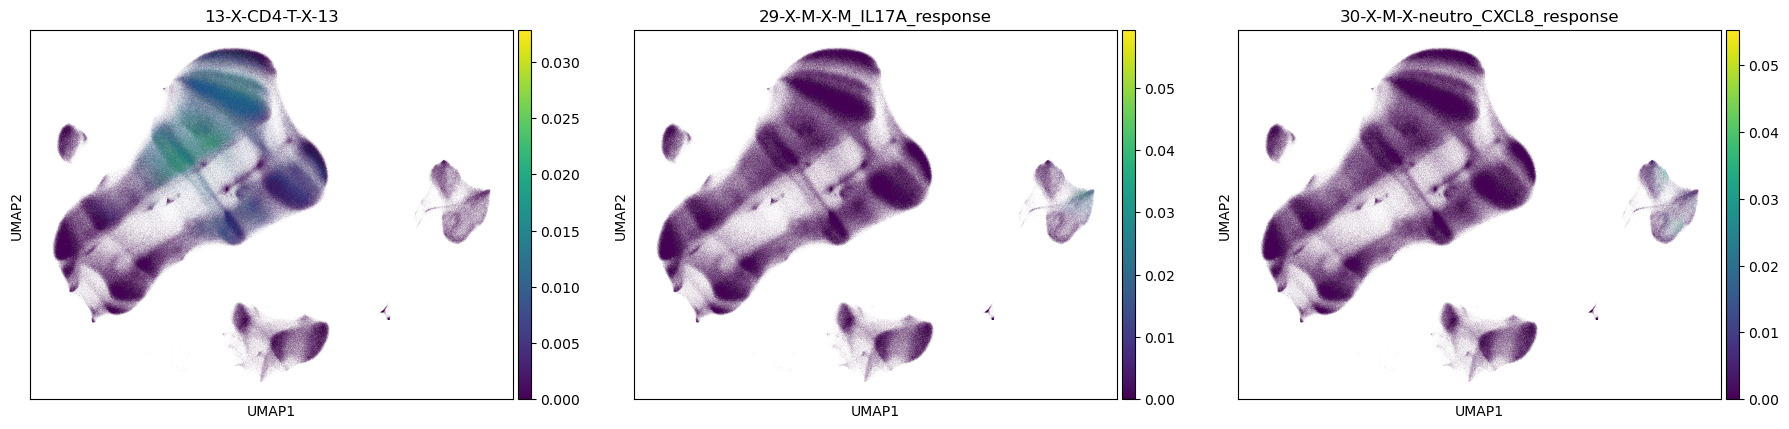

In [207]:
sc.pl.umap(adata, color=[factor_names[13],'29-X-M-X-M_IL17A_response','30-X-M-X-neutro_CXCL8_response'])

In [137]:
adata.uns['SPECTRA_markers'][29]

array(['IL1B', 'ITGB8', 'TNFAIP6', 'MIR3945HG', 'IDO1', 'IL6', 'C15orf48',
       'SOD2', 'MARCKS', 'IER3', 'CCL4L2', 'CCL4', 'G0S2', 'INHBA',
       'RNF144B', 'CXCL8', 'CCL3', 'CPM', 'SLAMF7', 'DOCK4', 'KYNU',
       'TNFAIP2', 'HCK', 'PTGS2', 'SLC1A3', 'NFKBIA', 'NCF1', 'TRAF1',
       'TNF', 'AC083837.1', 'MIR155HG', 'AQP9', 'NINJ1', 'AC025580.2',
       'SLC39A8', 'IL1A', 'MGLL', 'IRAK2', 'ADA', 'DRAM1', 'ALCAM',
       'NRP2', 'MS4A7', 'PSTPIP2', 'PSD3', 'BCL2A1', 'CCL20', 'PELI1',
       'CD80', 'SLC43A2'], dtype=object)

### Spectra and Memento comparison

I am going to relate the memento results to the Spectra results. My first approach will be to sum up the normalized spectra weights for DE genes, positive for up-regulated DE genes and negative for down-regulated DE genes

In [181]:
def sum_memento_spectra(dex, fdf):

    dex_sig = dex[multipletests(dex['de_pval'], method='fdr_bh', alpha=0.05)[0]]
    dex_fdf = dex[['gene','de_coef']].merge(fdf)

    return((np.sum(-dex_fdf[dex_fdf['de_coef'] < 0]['weight']) + 
            np.sum( dex_fdf[dex_fdf['de_coef'] > 0]['weight'])) /
           np.sum(fdf['weight']))

In [157]:
ctypes = ['B','CD4-T','CD8-T','NK','M','gdT']
#ctypes = ['B','CD4-T','NK','M','gdT']
memento_pop_l = []
for ctype in ctypes:
    
    for cond in ["IFN","LPS"]:

        for pop in ['Tikari','Fulani','CHG']:
            
            results = pd.read_csv("../memento/output/memento.{}.{}.CTL_{}.COND.csv".format(ctype,pop,cond), index_col=0)
            results['Ethnicity'] = pop
            results['ctype'] = ctype
            memento_pop_l.append(results)

In [158]:
memento_pop = pd.concat(memento_pop_l)

In [190]:
ctypes = ['B','CD4-T','CD8-T','NK','M','gdT']
#ctypes = ['B','CD4-T','NK','M','gdT']
memento_spectra_l = []
for ctype in ctypes:
    
    for cond in ["IFN","LPS"]:

        for pop in ['Tikari','Fulani','CHG']:

            for factor in range(41):

                dex = memento_pop[(memento_pop['Ethnicity']==pop) & \
                    (memento_pop['tx']==cond) & \
                    (memento_pop['ctype']==ctype)]
                
                fdf = pd.DataFrame({'gene': adata.var_names[adata.var['spectra_vocab']],
                                    'weight': adata.uns['SPECTRA_factors'][factor,:]})

                spectra_sum = sum_memento_spectra(dex, fdf)
                results = pd.DataFrame({'ctype': [ctype],
                                        'cond': [cond],
                                        'pop': [pop],
                                        'factor': [factor],
                                        'spectra_sum': [spectra_sum]})
                memento_spectra_l.append(results)

In [191]:
memento_spectra = pd.concat(memento_spectra_l)

<Axes: >

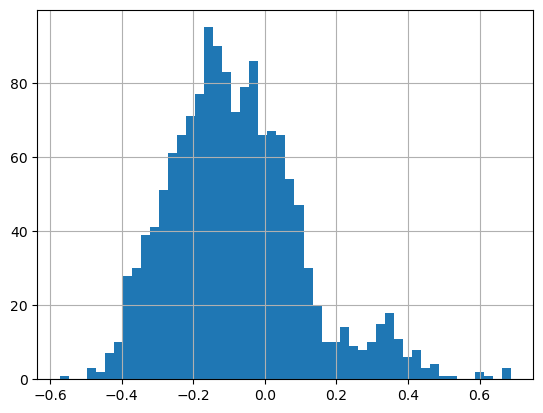

In [200]:
memento_spectra['spectra_sum'].hist(bins=50)

In [218]:
memento_spectra['index'] = ["{}_{}_{}".format(x,y,z) for x,y,z in zip(memento_spectra['ctype'], memento_spectra['cond'], memento_spectra['pop'])]

In [219]:
memento_spectra_wide = memento_spectra.pivot(index='index', columns='factor', values='spectra_sum')

<Figure size 1400x700 with 0 Axes>

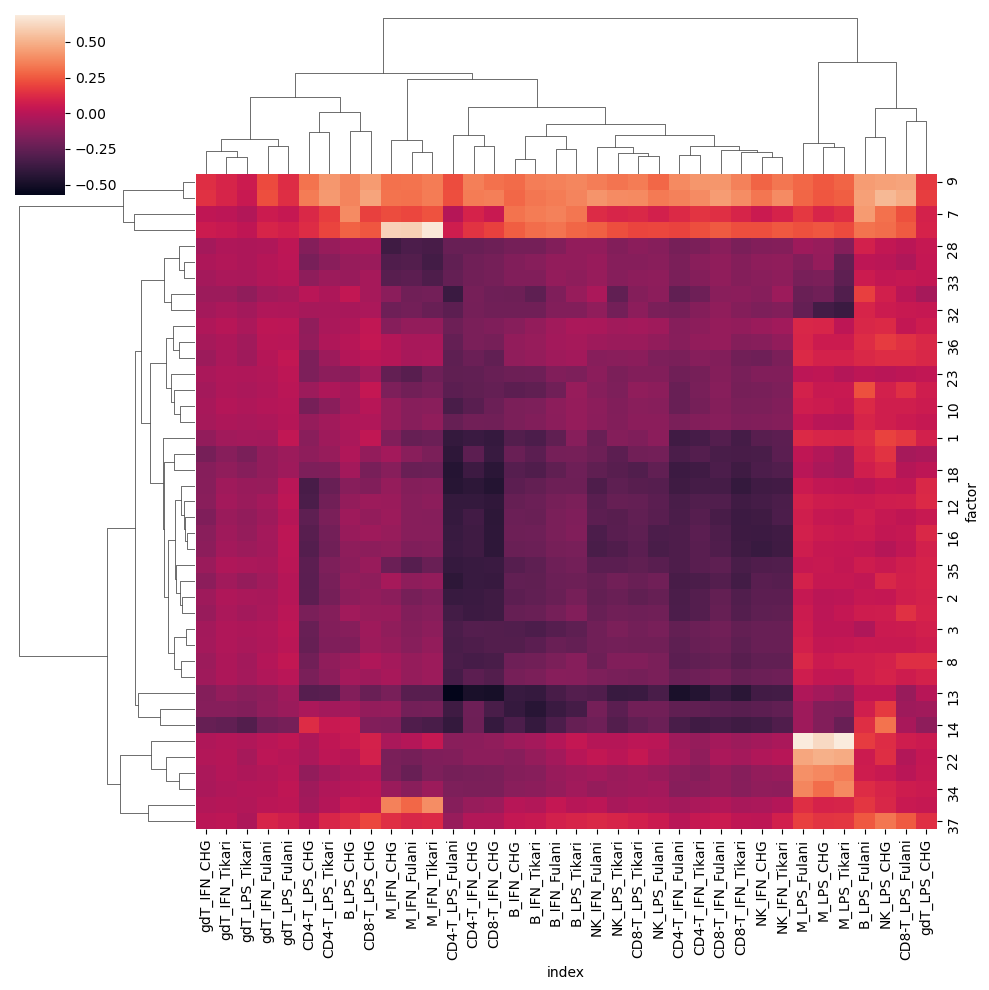

In [223]:
plt.figure(figsize=(14, 7))
sns.clustermap(memento_spectra_wide.transpose())

In [201]:
memento_spectra.sort_values("spectra_sum")

ctype cond     pop  factor  spectra_sum
0   CD4-T  LPS  Fulani      13    -0.572448
0   CD8-T  IFN     CHG      13    -0.496044
0   CD4-T  IFN     CHG      13    -0.484603
0   CD4-T  IFN  Fulani      13    -0.484276
0   CD8-T  IFN     CHG      20    -0.452747
..    ...  ...     ...     ...          ...
0       M  IFN     CHG      31     0.602755
0       M  LPS     CHG      29     0.623924
0       M  IFN  Tikari      31     0.676371
0       M  LPS  Tikari      29     0.685741
0       M  LPS  Fulani      29     0.687740

[1476 rows x 5 columns]

In [172]:
dex_sig = dex[multipletests(dex['de_pval'], method='fdr_bh', alpha=0.05)[0]]
dex_fdf = dex[['gene','de_coef']].merge(fdf)

In [178]:
np.sum(-dex_fdf[dex_fdf['de_coef'] < 0]['weight'])

-0.6147032576133511

In [180]:
np.sum( dex_fdf[dex_fdf['de_coef'] > 0]['weight'])

0.243329166049089

In [ ]:
(np.sum(-dex_fdf[dex_fdf['de_coef'] < 0]['weight']) + 
            np.sum( dex_fdf[dex_fdf['de_coef'] > 0]['weight'])) /
           np.sum(fdf['weight'])

gene   de_coef    weight
0       ISG15  3.261116  0.000002
1         SKI -0.415801  0.000330
2        RERE  0.152416  0.000292
3        ENO1  0.332925  0.000626
4      PIK3CD -0.264366  0.000166
...       ...       ...       ...
1881    TMLHE -0.196100  0.000045
1882  MT-ATP6 -0.054482  0.001682
1883   MT-CO3 -0.055413  0.001467
1884   MT-ND3 -0.068988  0.001108
1885   MT-CYB -0.055571  0.001122

[1886 rows x 3 columns]

In [182]:
sum_memento_spectra(foo, spectra_df)

-0.1510560488576874

In [148]:
memento_pop.sort_values('de_pval').head(20)

gene   tx   de_coef     de_se  de_pval   dv_coef     dv_se  \
1564      TXK  IFN -0.432572  0.006824      0.0  0.054085  0.014819   
3055    DDX58  IFN  2.102920  0.012157      0.0  0.036419  0.044767   
3095     STOM  IFN  0.912482  0.009425      0.0 -0.002865  0.025182   
6117      MX1  LPS  1.724469  0.005976      0.0  0.129033  0.029631   
3060   DNAJA1  IFN  0.969422  0.009566      0.0  0.028324  0.044014   
3063     BAG1  IFN  1.304813  0.015215      0.0 -0.004260  0.098137   
3064    CHMP5  IFN  0.803024  0.015770      0.0  0.045972  0.085024   
6116      MX2  LPS  1.110909  0.005253      0.0  0.242355  0.020593   
3837    CALM1  IFN  0.442635  0.010580      0.0 -0.102693  0.035576   
6108    MORC3  LPS  0.180806  0.004156      0.0  0.071934  0.019681   
3101    STRBP  IFN -0.414962  0.008798      0.0  0.136598  0.021043   
3689   OSBPL8  IFN -0.388313  0.009200      0.0  0.028301  0.029962   
393    PLAAT4  IFN  0.886333  0.021990      0.0  0.549168  0.138051   
3107     SCAI  IFN -0.509615  0.009150      0.0  0.122446  0.022839   
4176   PARP11  LPS  0.710554  0.015564      0.0 -0.052774  0.052004   
4768   ZCCHC2  IFN  1.514600  0.017401      0.0 -0.411673  0.061843   
3081     PAX5  IFN  0.417071  0.008963      0.0 -0.336508  0.029357   
3112     PBX3  IFN -0.355345  0.008037      0.0  0.094732  0.016069   
3116  FAM102A  IFN -0.352011  0.005175      0.0  0.104435  0.024374   
3117  C9orf16  IFN -0.266587  0.005692      0.0 -0.056912  0.029614   

           dv_pval Ethnicity  
1564  1.526247e-04    Tikari  
3055  9.688552e-01    Fulani  
3095  6.782861e-01    Tikari  
6117  3.533075e-03    Tikari  
3060  9.059256e-01    Fulani  
3063  5.689881e-01    Fulani  
3064  8.407997e-01    Fulani  
6116  6.071772e-29    Tikari  
3837  2.892399e-03    Fulani  
6108  4.323484e-04    Tikari  
3101  3.271890e-10    Tikari  
3689  3.369353e-01    Tikari  
393   1.007034e-04    Tikari  
3107  4.272687e-08    Tikari  
4176  1.917113e-01    Tikari  
4768  1.401634e-11    Fulani  
3081  1.030275e-30    Fulani  
3112  3.843170e-09    Tikari  
3116  1.603103e-05    Tikari  
3117  1.033565e-01    Tikari

### Recluster Myeloid cells

In [4]:
adata_raw = sc.read_h5ad("../../test/test123/write/qc_020725_raw.h5ad", backed='r')

In [5]:
adata_m = adata_raw[adata_raw.obs['cytopus_names']=="M"].to_memory()

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
# log normalize for use with Scanpy sam command
sc.pp.log1p(adata_m)

In [ ]:
sam_obj = sce.tl.sam(adata_m, inplace=True)

In [ ]:
adata_m.write("output/gex_080125.Myeloid.sam.k20.h5ad")

In [25]:
sam_obj = sce.tl.sam(adata_m, k=100, inplace=True)

RUNNING SAM
Iteration: 0, Convergence: 1.0
Iteration: 1, Convergence: 0.8831112092277157
Iteration: 2, Convergence: 0.016098257882025034
Computing the UMAP embedding...


/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Elapsed time: 1780.1405889987946 seconds


In [26]:
adata_m.write("output/gex_080125.Myeloid.sam.k100.h5ad")

In [11]:
adata_m = sc.read_h5ad("output/gex_080125.Myeloid.sam.k100.h5ad")

<Axes: >

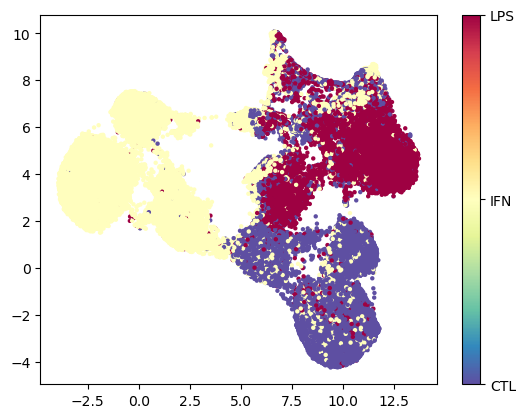

In [27]:
sce.pl.sam(adata_m, projection='X_umap', c='COND')

In [14]:
len(adata_m.uns['dimred_indices'])

3000

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_

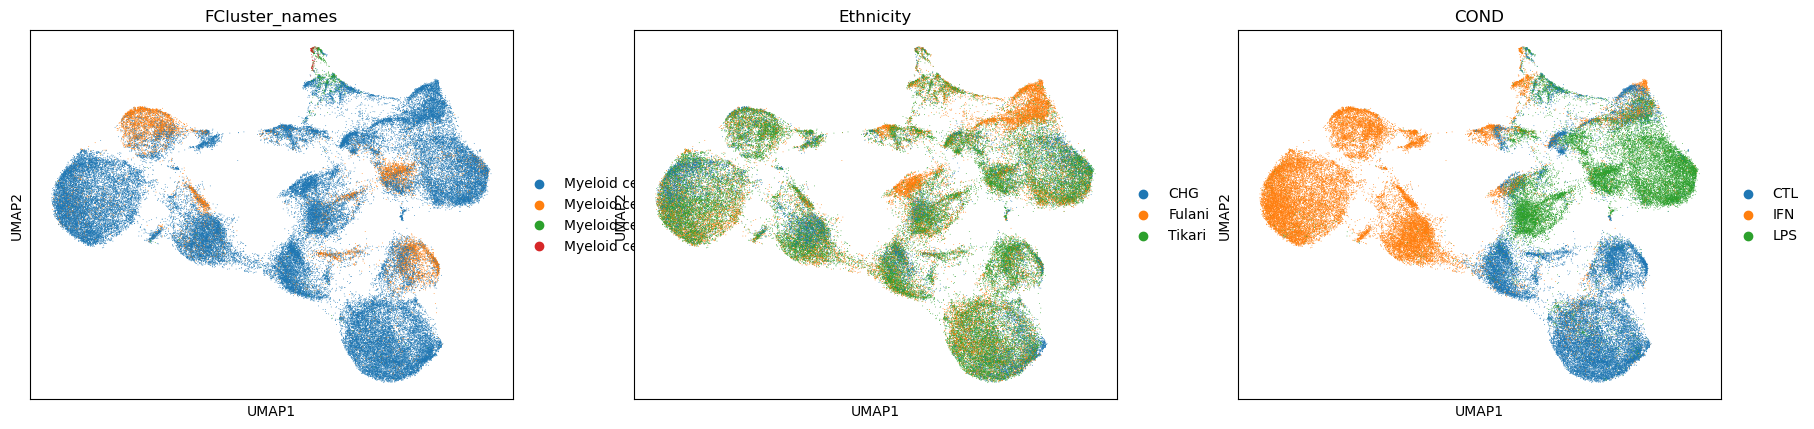

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_

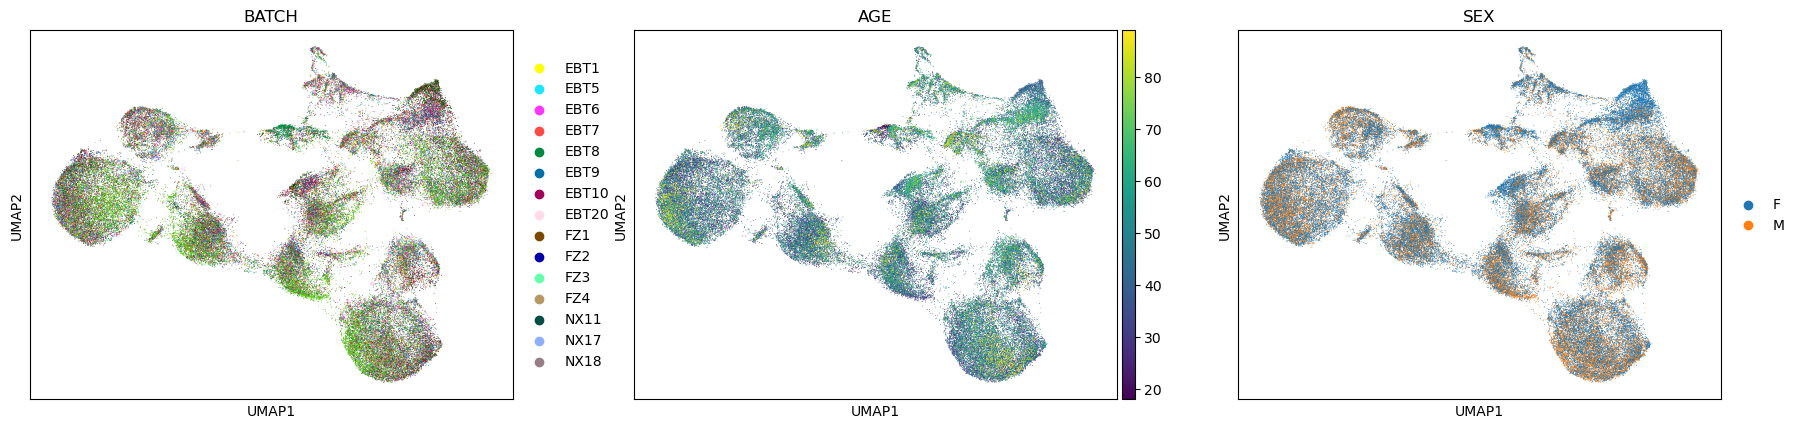

In [28]:
sc.pl.umap(adata_m, color=['FCluster_names','Ethnicity','COND'])
sc.pl.umap(adata_m, color=['BATCH','AGE','SEX'])

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


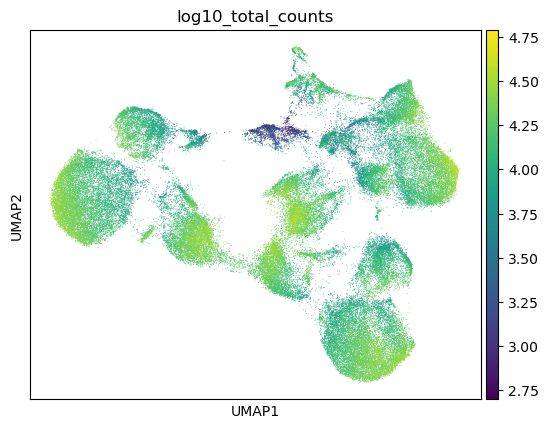

In [8]:
sc.pl.umap(adata, color=['log10_total_counts'])

In [36]:
scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'], index=adata.obs.index, columns=adata.uns['SPECTRA_overlap'].index)

In [41]:
adata_m.obs[scores_df.columns] = scores_df.loc[adata_m.obs_names,:]

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


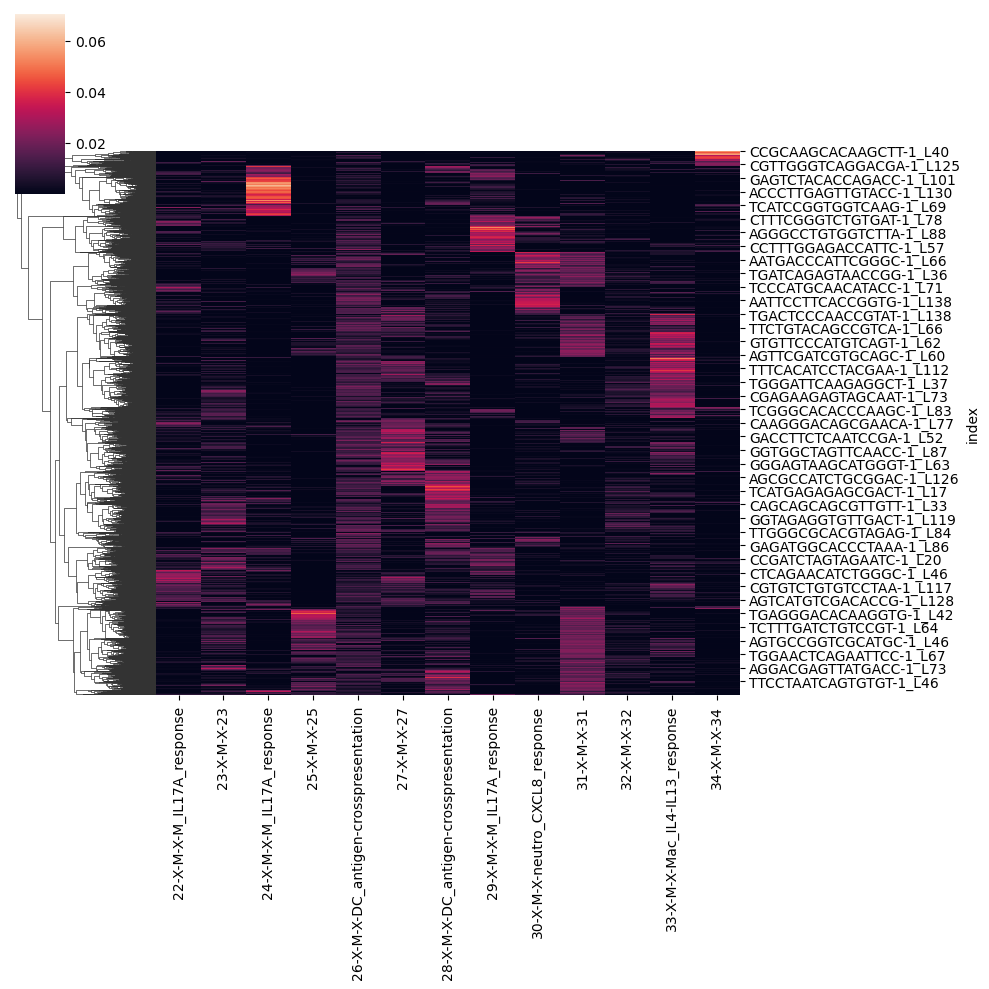

In [81]:
sns.clustermap(adata_m.obs[list(scores_df.columns[22:35])], col_cluster=False)

/home/derkelly/miniconda3/envs/memento/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


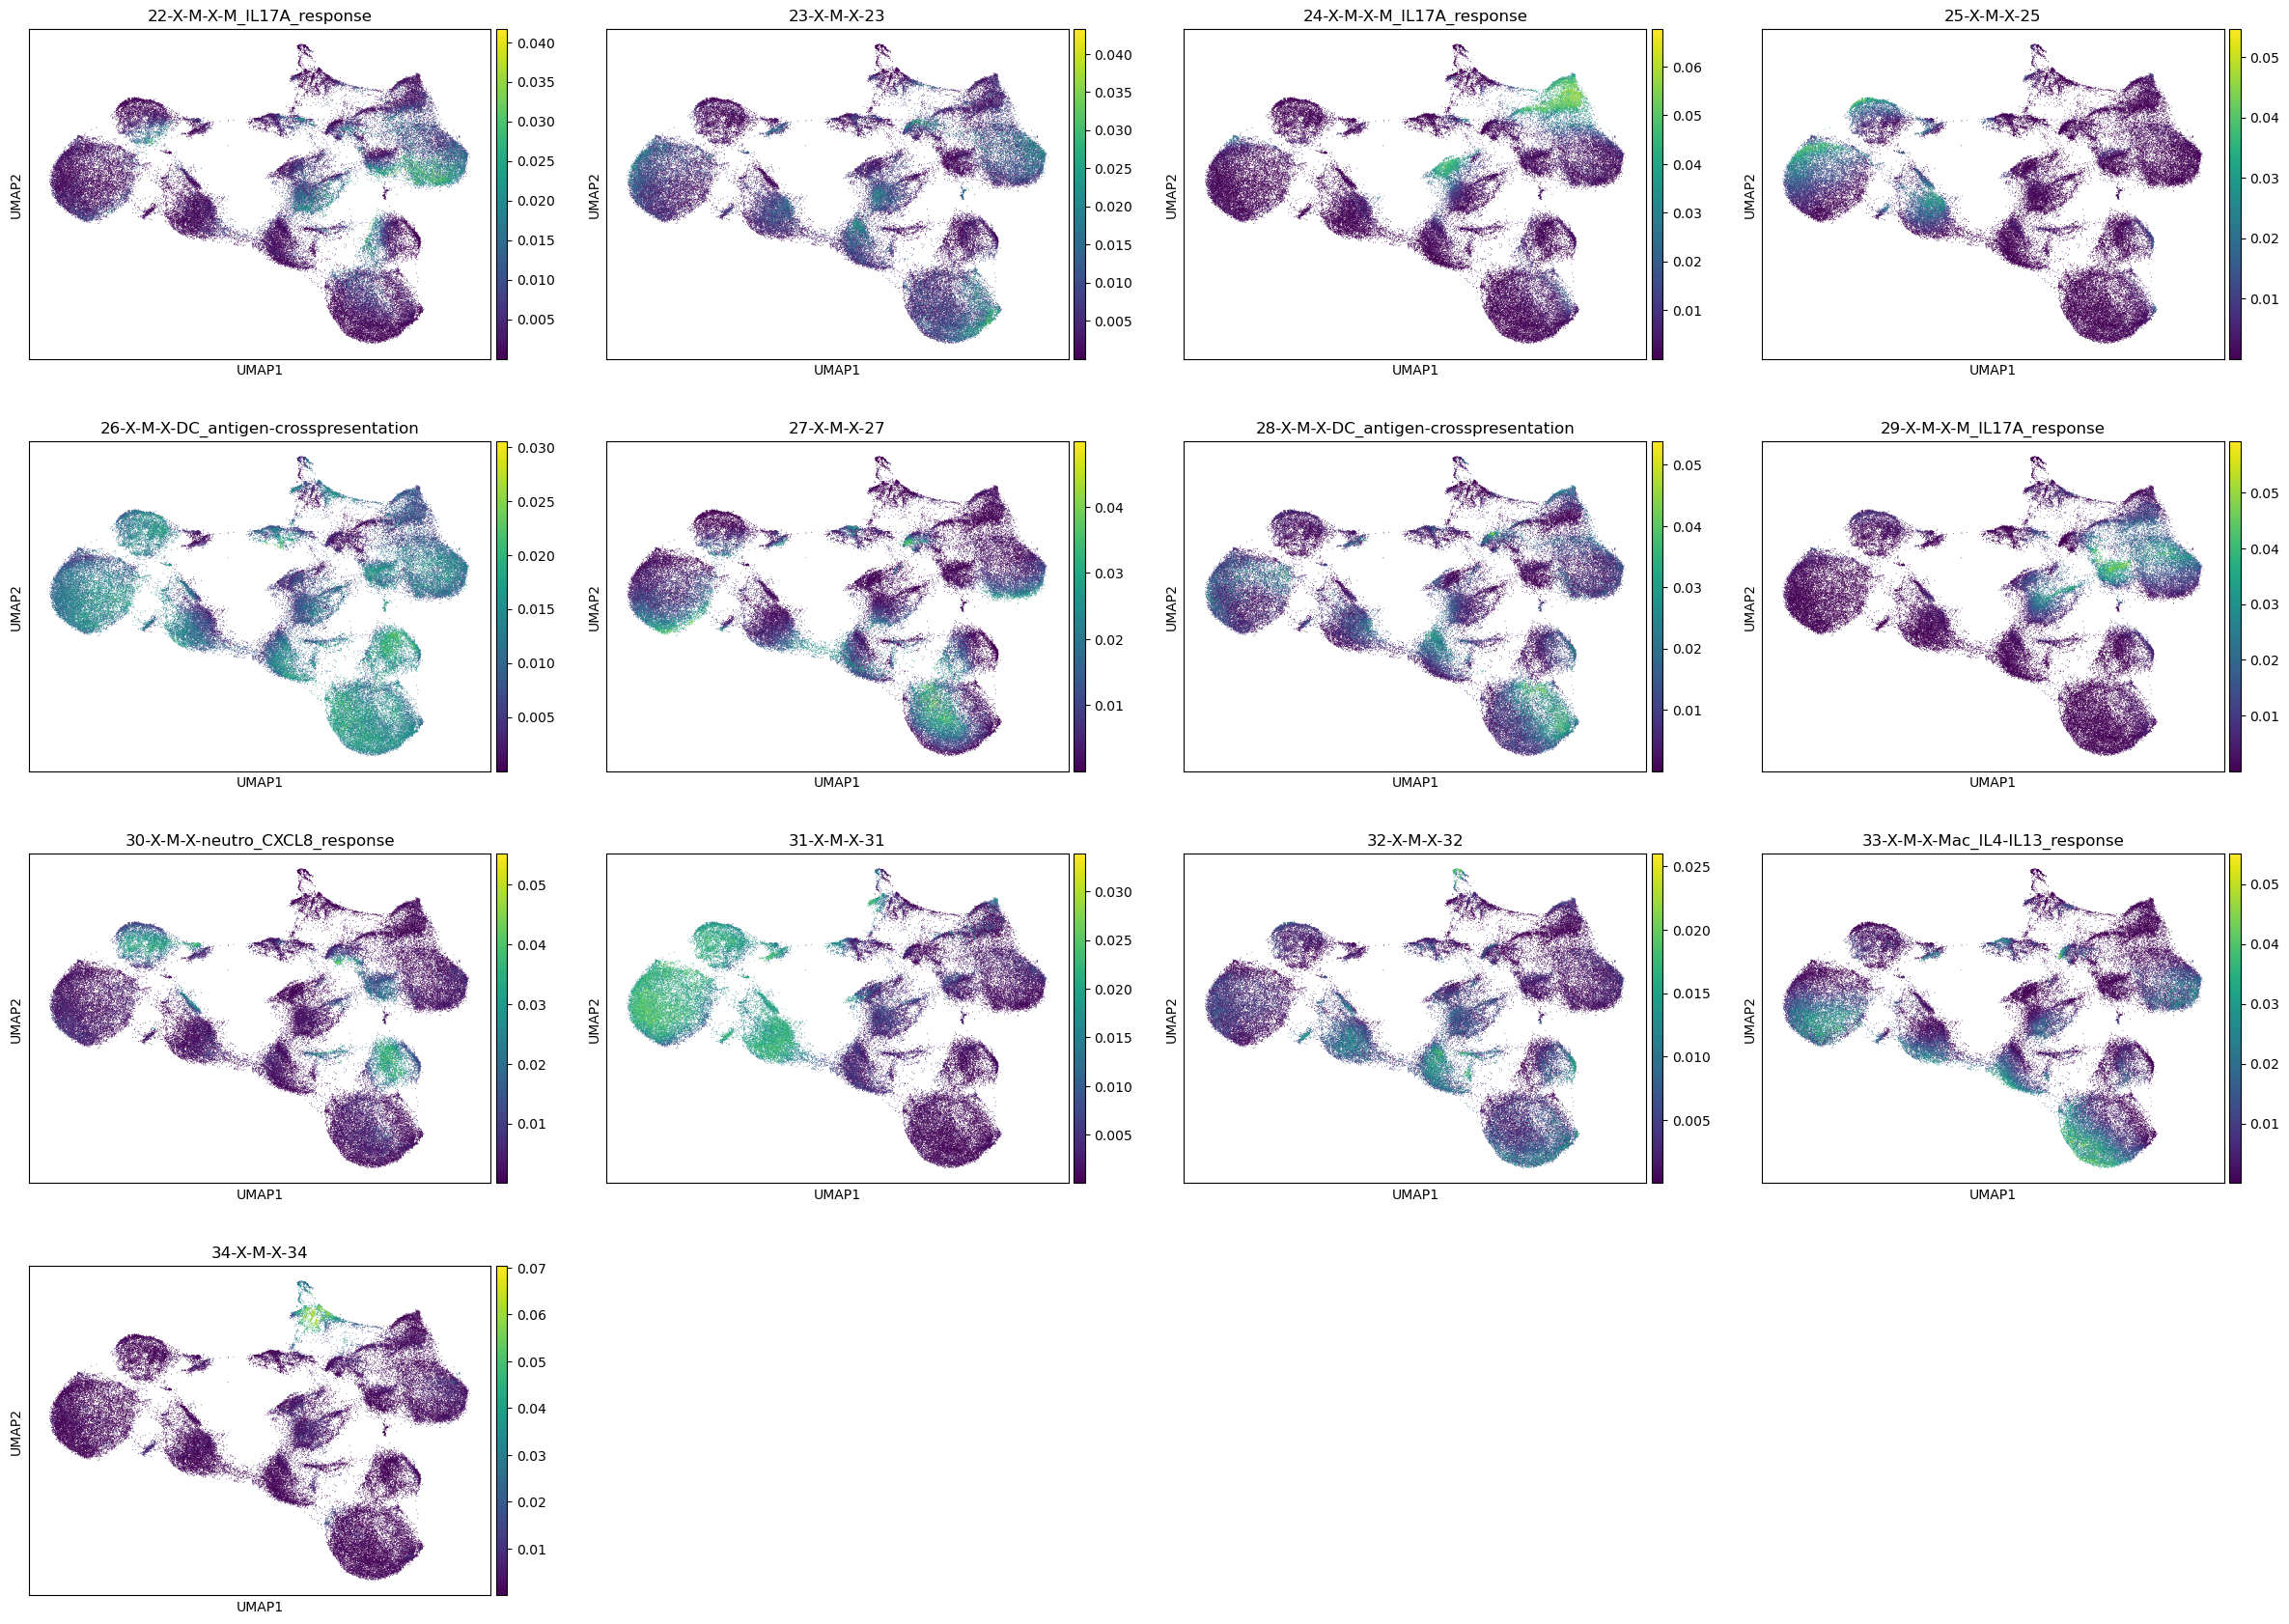

In [73]:
sc.pl.umap(adata_m, color=list(scores_df.columns[22:35]))

In [64]:
adata.uns['SPECTRA_markers'][22]

array(['CXCL8', 'CCL3L1', 'CCL3', 'CCL1', 'SERPINB2', 'CCL4', 'IL1B',
       'INHBA', 'CXCL3', 'IER3', 'CCL4L2', 'CXCL2', 'C15orf48', 'TNFSF15',
       'PLAUR', 'TNF', 'CSF1', 'CCL2', 'LUCAT1', 'SLC7A11', 'UPP1',
       'ATF3', 'IL1RN', 'DUSP6', 'TIMP1', 'FCGR2A', 'DOCK4', 'CSF2',
       'NRP1', 'BCAT1', 'F3', 'SOD2', 'FTH1', 'TXN', 'PPIF', 'PLEK',
       'RGS16', 'HBEGF', 'PPP1R15A', 'CTSL', 'ETS2', 'ITGAX', 'CCL7',
       'CDKN1A', 'PHLDA2', 'TM4SF19', 'AP000331.1', 'OGFRL1', 'CREB5',
       'IL1R1'], dtype=object)

In [47]:
adata.uns['SPECTRA_markers'][24]

array(['CXCL5', 'IL1B', 'SERPINB2', 'CXCL3', 'CXCL8', 'CXCL1', 'PID1',
       'S100A9', 'EREG', 'CXCL2', 'MT1G', 'S100A8', 'SOX5', 'IER3',
       'CCL3L1', 'AC025580.2', 'GLIS3', 'FCER1G', 'CD14', 'CCL3',
       'C15orf48', 'EPB41L3', 'TLR2', 'THBS1', 'MMP14', 'NAMPT',
       'TNFAIP6', 'CTSL', 'MT1H', 'ITGB8', 'PTGS2', 'ABCA1', 'HCK',
       'PLAUR', 'IL24', 'MET', 'SLC7A11', 'MT1M', 'PILRA', 'DOCK4',
       'CCL4', 'SLC25A37', 'SOD2', 'IL1A', 'ANPEP', 'KYNU', 'MARCKS',
       'SNX9', 'MT1E', 'MT1F'], dtype=object)

In [48]:
adata.uns['SPECTRA_markers'][29]

array(['IL1B', 'ITGB8', 'TNFAIP6', 'MIR3945HG', 'IDO1', 'IL6', 'C15orf48',
       'SOD2', 'MARCKS', 'IER3', 'CCL4L2', 'CCL4', 'G0S2', 'INHBA',
       'RNF144B', 'CXCL8', 'CCL3', 'CPM', 'SLAMF7', 'DOCK4', 'KYNU',
       'TNFAIP2', 'HCK', 'PTGS2', 'SLC1A3', 'NFKBIA', 'NCF1', 'TRAF1',
       'TNF', 'AC083837.1', 'MIR155HG', 'AQP9', 'NINJ1', 'AC025580.2',
       'SLC39A8', 'IL1A', 'MGLL', 'IRAK2', 'ADA', 'DRAM1', 'ALCAM',
       'NRP2', 'MS4A7', 'PSTPIP2', 'PSD3', 'BCL2A1', 'CCL20', 'PELI1',
       'CD80', 'SLC43A2'], dtype=object)

In [82]:
adata.uns['SPECTRA_markers'][34]

array(['AK8', 'CCL22', 'PSD3', 'LNCAROD', 'CREB5', 'SLC7A11', 'CRLF2',
       'CSF2RA', 'ARMC9', 'IDO1', 'CXCL8', 'LYZ', 'KYNU', 'NR4A3',
       'ITGB8', 'MGLL', 'NRP2', 'ABTB2', 'LAMP3', 'OGFRL1', 'CRIM1',
       'PALLD', 'MARCKS', 'GPAT3', 'EREG', 'FSCN1', 'BIRC3', 'TNFAIP2',
       'CD83', 'CCR7', 'PGD', 'TFPI', 'BASP1', 'SPRED2', 'CKB',
       'ROR1-AS1', 'EBI3', 'CREG1', 'TRAF1', 'DUSP5', 'REL', 'IL13RA1',
       'TXN', 'RGL1', 'RDX', 'GM2A', 'ST3GAL6', 'STX17-AS1', 'TXNRD1',
       'HLA-DRB1'], dtype=object)

In [68]:
factor=22
tmp_results = enr_results_rel[factor]
tmp_results[tmp_results['Gene_set']=="MSigDB_Hallmark_2020"].sort_values('P-value').head()

Gene_set                           Term Overlap       P-value  \
0  MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB  30/200  1.695736e-36   
1  MSigDB_Hallmark_2020          Inflammatory Response  22/200  1.144881e-23   
2  MSigDB_Hallmark_2020       IL-6/JAK/STAT3 Signaling   12/87  1.609482e-14   
3  MSigDB_Hallmark_2020                     Complement  14/200  1.315163e-12   
4  MSigDB_Hallmark_2020              KRAS Signaling Up  13/200  2.242637e-11   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      7.291667e-35            0                     0   49.739496   
1      2.461494e-22            0                     0   31.250648   
2      2.306924e-13            0                     0   36.045455   
3      1.413800e-11            0                     0   17.254064   
4      1.928668e-10            0                     0   15.751982   

   Combined Score                                              Genes  \
0     4096.790897  PPP1R15A;CEBPB;CDKN1A;CSF2;CSF1;PLEK;CXCL1;CXC...   
1     1650.789135  CDKN1A;CXCL8;CSF1;CD82;IL1R1;TNFSF15;RGS16;C5A...   
2     1144.813693  SOCS3;CSF2;CSF1;CCL7;IL1R1;IL1B;IL3RA;CXCL1;CX...   
3      472.020458  DUSP5;DOCK4;CEBPB;SERPINB2;TFPI2;ANXA5;PLEK;PL...   
4      386.250947  PPP1R15A;NRP1;CSF2;RGS16;PLAUR;INHBA;TNFRSF1B;...   

                      factor  
0  22-X-M-X-M_IL17A_response  
1  22-X-M-X-M_IL17A_response  
2  22-X-M-X-M_IL17A_response  
3  22-X-M-X-M_IL17A_response  
4  22-X-M-X-M_IL17A_response

In [69]:
factor=24
tmp_results = enr_results_rel[factor]
tmp_results[tmp_results['Gene_set']=="MSigDB_Hallmark_2020"].sort_values('P-value').head()

Gene_set                               Term Overlap  \
0  MSigDB_Hallmark_2020      TNF-alpha Signaling via NF-kB  26/200   
1  MSigDB_Hallmark_2020              Inflammatory Response  22/200   
2  MSigDB_Hallmark_2020                         Complement  15/200   
3  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition  11/200   
4  MSigDB_Hallmark_2020                  KRAS Signaling Up  10/200   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  6.951384e-30      2.432984e-28            0                     0   
1  1.144881e-23      2.003541e-22            0                     0   
2  7.081836e-14      8.262142e-13            0                     0   
3  4.948613e-09      4.330036e-08            0                     0   
4  6.326649e-08      4.428654e-07            0                     0   

   Odds Ratio  Combined Score  \
0   39.831935     2674.260855   
1   31.250648     1650.789135   
2   18.806041      569.421696   
3   12.889900      246.508483   
4   11.526316      191.059173   

                                               Genes  \
0  CEBPB;PFKFB3;TNFAIP6;TNFAIP2;CXCL1;CXCL3;PTGS2...   
1  ABCA1;LYN;CXCL8;TNFAIP6;CCL20;AQP9;PLAUR;TNFRS...   
2  LYN;DOCK4;CEBPB;SERPINA1;FCER1G;SERPINB2;TFPI2...   
3  MMP14;CXCL8;BASP1;MMP1;ANPEP;TFPI2;PLAUR;CXCL1...   
4  NRP1;FCER1G;CCL20;IL1B;EPB41L3;PLAUR;TNFRSF1B;...   

                      factor  
0  24-X-M-X-M_IL17A_response  
1  24-X-M-X-M_IL17A_response  
2  24-X-M-X-M_IL17A_response  
3  24-X-M-X-M_IL17A_response  
4  24-X-M-X-M_IL17A_response

In [74]:
factor=34
tmp_results = enr_results_rel[factor]
tmp_results[tmp_results['Gene_set']=="MSigDB_Hallmark_2020"].sort_values('P-value').head()

Gene_set                           Term Overlap       P-value  \
0  MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB  15/200  7.081836e-14   
1  MSigDB_Hallmark_2020          Inflammatory Response  15/200  7.081836e-14   
2  MSigDB_Hallmark_2020      Interferon Gamma Response  10/200  6.326649e-08   
3  MSigDB_Hallmark_2020       IL-6/JAK/STAT3 Signaling    6/87  4.888936e-06   
4  MSigDB_Hallmark_2020           IL-2/STAT5 Signaling   7/199  6.366349e-05   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      1.239321e-12            0                     0   18.806041   
1      1.239321e-12            0                     0   18.806041   
2      7.381091e-07            0                     0   11.526316   
3      4.277819e-05            0                     0   15.617809   
4      3.832814e-04            0                     0    7.726030   

   Combined Score                                              Genes  \
0      569.421696  DUSP5;CD83;GADD45A;TNFAIP2;TRAF1;SOD2;ETS2;NFK...   
1      569.421696  PTGIR;CALCRL;CCL22;CXCL8;IL15;EBI3;AHR;EREG;NF...   
2      191.059173  NFKBIA;CD74;IL15;IRF4;TNFAIP2;PDE4B;SOD2;HLA-D...   
3      190.982942              IL3RA;EBI3;PDGFC;CSF2RA;IL13RA1;CRLF2   
4       74.648129             SPRED2;CD83;ALCAM;IRF4;IL3RA;AHR;TRAF1   

        factor  
0  34-X-M-X-34  
1  34-X-M-X-34  
2  34-X-M-X-34  
3  34-X-M-X-34  
4  34-X-M-X-34